# Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Считаем данные

In [2]:
data = pd.read_csv("X_train.csv",encoding='cp1251', sep =',')

In [3]:
data = data.rename(columns={"v1":"label", "v2":"text"})

In [4]:
data.head()

,label,text
0,ham,I tot u outside cos darren say u come shopping...
1,ham,Arun can u transfr me d amt
2,ham,what are your new years plans?
3,spam,"January Male Sale! Hot Gay chat now cheaper, c..."
4,ham,Ya that one is slow as poo


# Целевое событие составляет

In [7]:
100*data.label.value_counts()/data.shape[0]

ham     86.591356
spam    13.408644
Name: label, dtype: float64

# Конвертируем целевое событие

In [8]:
data['label_num'] = data.label.map({'ham':0, 'spam':1})

# Добавляем новую переменную, длина сообщения

In [12]:
data['length'] = data['text'].apply(len)
data.head(3)

,label,text,label_num,length
0,ham,I tot u outside cos darren say u come shopping...,0,110
1,ham,Arun can u transfr me d amt,0,27
2,ham,what are your new years plans?,0,30


# Давайте визуализируем распределение данной величины в разрезе целевого поля

Text(0.5,1,'length distribution - Spam V.S. Hum')

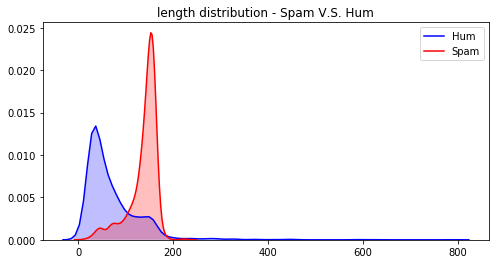

In [14]:
fig = plt.figure(figsize=(8,4),)
ax=sns.kdeplot(data.loc[(data['label_num'] == 0), 'length'] , color='b', shade=True,label='Hum')
ax=sns.kdeplot(data.loc[(data['label_num'] == 1), 'length'] , color='r', shade=True, label='Spam')
plt.title('length distribution - Spam V.S. Hum')

> Картина следующая, спам сообщения длиннее в среднем.

In [95]:
churn_summary = data.groupby('label_num')
q = churn_summary.mean().T
q

label_num,0,1
length,70.77283,137.910256


> **Неспам** средняя длина сообщений: **70.77283**

> **Cпам** средняя длина сообщений: **137.910256**

# Подключаем библиотеки

In [15]:
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

# Удаляем стоп-слова

In [19]:
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}' ,'\\', '//', ';', ':']) 
stop_words.update([str(i) for i in range(10)])

> Создали словарь стоп-слов

In [21]:
def preprocess(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stop_words]
    return " ".join(filtered_words)

In [22]:
sentence = "At eight o'clock on Thursday morning Arthur didn't feel and very good. French-Fries my country"
print(preprocess(sentence))

eight clock thursday morning arthur feel good french fries country


In [23]:
data['text'] = data['text'].map(preprocess)

## Стемминг

In [86]:
import nltk
sno = nltk.stem.SnowballStemmer('english')
sno.stem('converting')

'convert'

In [87]:
def preprocess_stem(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [ sno.stem(w) for w in tokens]
    return " ".join(filtered_words)
data['text'] = data['text'].map(preprocess_stem)

# Масштабируем длину сообщений

In [88]:
len_sms = data['length'].as_matrix()
#len_sms

# Преобразуем признаковое пространство

In [89]:
from scipy.sparse import csr_matrix 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = CountVectorizer().fit(data.text)
X = vectorizer.transform(data.text)
X = np.hstack((X.todense(),len_sms[:, None]))

# Naive Bayes

In [90]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
score = cross_val_score(cv=5, estimator=clf, X=X, y=data.label_num, scoring='roc_auc', n_jobs=-1)
print ('Mean ROC_AUC: {:.4}'.format(np.mean(score)))
print(score)

Mean ROC_AUC: 0.9755
[ 0.98521762  0.98338213  0.95786323  0.97498861  0.97587351]


> Модель стабильна, и показывает хороший результат.

# Train / Test

In [91]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
X_train, X_test, y_train, y_test = train_test_split(X, data.label_num.values, test_size = 0.2, random_state = 23)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

3257 815


In [92]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [111]:
roc = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1] )
print(roc, ' - RocAuc')
print('--------------')
acc = accuracy_score(y_test, clf.predict(X_test))
print('Accuracy -', 100*acc,'%')

0.972189334517  - RocAuc
--------------
Accuracy - 97.9141104294 %


In [94]:
pred = clf.predict_proba(X_test)[:,1]
all_pred = pd.DataFrame(np.vstack([y_test, pred])).T
all_pred.columns = ['true', 'prob']
all_pred.sort_values('prob', ascending=False, inplace=True)

# Отсечка

> Выбираем наилучшее отсечение.

In [106]:
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
y_true = all_pred['true']
recall = []
precision = []
score = []
roc_auc= []
aa = np.sort(all_pred['prob'].unique())
for i in range(0, len(aa), 10):
    f = lambda x: 1 if x >aa[i] else 0
    score.append(aa[i])
    y_pred = all_pred['prob'].map(f)
    g=recall_score(y_true, y_pred, average='binary')
    recall.append(g)
    p = precision_score(y_true, y_pred, average='binary')
    precision.append(p)
    f =roc_auc_score(y_true, y_pred)
    roc_auc.append(f)

In [107]:
acc_score = pd.DataFrame(np.vstack([score, roc_auc]).T)
acc_score.columns = ['score', 'roc_auc_score']
acc_score.loc[acc_score['roc_auc_score'] ==acc_score['roc_auc_score'].max(), 'score'].values

array([ 0.20855349])

In [108]:
accuracy_score(all_pred['true'], all_pred['prob'].map(lambda x: 1 if x >0.20831917 else 0).tolist())

0.97423312883435587

# Визуализируем

>Попробуем визуализировать данные на плоскости для наглядности. Пробуем метод понижения размерности на плоскость и TSNE

In [78]:
%%time
from sklearn import manifold
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(X_test)

Wall time: 40.2 s


> Посмотрим, насколько хорошо отделяются сообщения spam от ham на one-hold выборке(y_predicted как маркеровка)

Populating the interactive namespace from numpy and matplotlib
Wall time: 77.6 ms


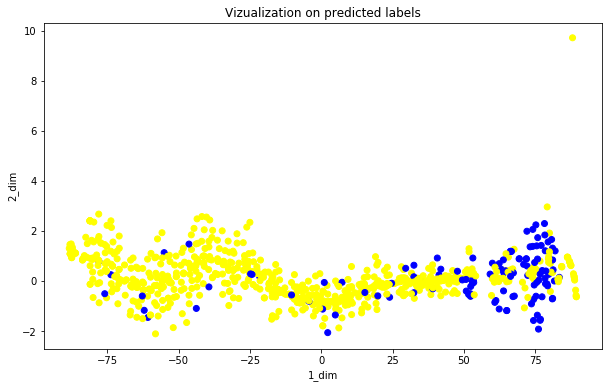

In [79]:
%%time
%pylab inline
pylab.figure(figsize = (10, 6))
colors = ['yellow','blue']
plt.xlabel('1_dim')
plt.ylabel('2_dim')
plt.title('Vizualization on predicted labels')
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c =[1 if x>0.23593308 else 0 for x in pred], cmap=matplotlib.colors.ListedColormap(colors) )

## Посмотрим, насколько хорошо отделяются сообщения spam от ham на one-hold выборке(y_test как маркировка)

Populating the interactive namespace from numpy and matplotlib


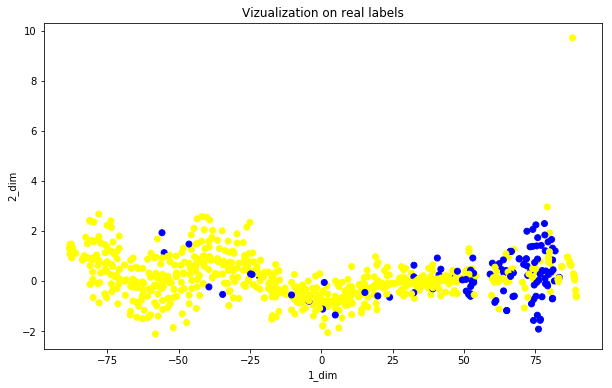

In [81]:
%pylab inline
pylab.figure(figsize = (10, 6))
colors = ['yellow','blue']
plt.xlabel('1_dim')
plt.ylabel('2_dim')
plt.title('Vizualization on real labels')
pylab.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c =y_test, cmap=matplotlib.colors.ListedColormap(colors) )

>Видно, что результаты отделения ham от spam при понижении размерности есть - spam выделился в отдельный сектор.

# Скорим выборку

In [99]:
data_test = pd.read_csv("X_test.csv",encoding='cp1251', sep =',')

In [100]:
data_test['text_transf'] = data_test['text'].map(preprocess)

In [101]:
data_test['text_transf'] = data_test['text_transf'].map(preprocess_stem)

In [105]:
data_test['length'] = data_test['text_transf'].apply(len)
len_sms = data_test['length'].as_matrix()
len_sms = (len_sms - min(len_sms))/ (max(len_sms)- min(len_sms)) 
X_test_df = vectorizer.transform(data_test['text'])
X_test_df = np.hstack((X_test_df.todense(),len_sms[:, None]))

In [157]:
data_test['label'] = pred_test
data_test['label'] = data_test['label'].map(lambda x: 'spam' if x >0.23593308 else 'ham')

In [158]:
data_test.drop('length',axis= 1, inplace=True)

In [159]:
data_test.drop('text_transf', axis=1, inplace=True)

In [161]:
data_test.to_csv('test_spam_detection.csv', sep = ',',index=False)

# Вывод.
> Мы построили модель выбрав в качестве основной: Наи́вный ба́йесовский классифика́тор

>**Модель** хорошо показала себя на кросс-валидации. Т.е. она стабильно показывает хорошее качество.

>0.972189334517  - **RocAuc**

>Accuracy - **97.9141104294 %**

--------------